In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Read historical wheat data 
- for Argentina on municipality level
- from 1969-2022

In [78]:
df = (pd
      .read_csv("data/crop/historical_wheat_data_argentina.csv", encoding="latin-1", sep=";")
      .drop(columns={"Cultivo", "idProvincia", "idDepartamento", "Sup. Sembrada"}))

df.columns = ["year", "province", "municipality", "harvested area [ha]", "production [t]", "yield [kg/ha]"]


"""
"Campaña" is based on USDA marketing year defintion. Argentinian wheat season spans from June-Dec. 
The following paragraph from USDA from April 2023 indicates how the first year number (e.g. XXXX in XXXX/YY) is relevant for our crop forecasts.

Post estimates Argentine wheat production to rebound to 19.5 million metric tons (MMT) in marketing year (MY) 2023/24, 
resulting in wheat exports of 13.7 MMT (including wheat flour as its wheat equivalent). However after the severe drought in MY 2022/23, 
more rains are needed to recharge soil moisture profiles before the June planting window (from: https://www.fas.usda.gov/data/argentina-grain-and-feed-annual-9)
"""
df["year"] = df["year"].str[:4].astype(int)

df = df.loc[df["year"] >= 1989].reset_index(drop=True) # because of SCM availability

df.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha]
0,1989,BUENOS AIRES,25 DE MAYO,32000,60100,1878
1,1990,BUENOS AIRES,25 DE MAYO,38400,84500,2201
2,1991,BUENOS AIRES,25 DE MAYO,21000,48300,2300
3,1992,BUENOS AIRES,25 DE MAYO,16800,43700,2601
4,1993,BUENOS AIRES,25 DE MAYO,14000,28000,2000


We filter by provinces with relevant production

In [80]:
production_by_province = df.groupby("province")["production [t]"].sum().reset_index().sort_values(by="production [t]", ascending=False).reset_index(drop=True)
production_by_province["production [t]"] = np.round(100 * production_by_province["production [t]"] / df["production [t]"].sum(), 2)
production_by_province.head(10)

,province,production [t]
0,BUENOS AIRES,55.64
1,SANTA FE,15.42
2,CORDOBA,14.24
3,ENTRE RIOS,5.59
4,LA PAMPA,4.57
5,SANTIAGO DEL ESTERO,2.03
6,TUCUMAN,0.78
7,CHACO,0.73
8,SALTA,0.68
9,CATAMARCA,0.18


Buenos Aires, Santa Fe, Cordoba, Entre Rios, and La Pampa contribute most of Argentinian wheat production. We will only focus on these 5 provinces from now on. In addition, these are the provinces with similar soil and climate conditions (Espinal, Pampas)

In [81]:
df = df.loc[df["province"].isin(['BUENOS AIRES', 'CORDOBA', 'ENTRE RIOS', 'LA PAMPA', 'SANTA FE'])].reset_index(drop=True)

Filter by municipalities with complete time series

In [82]:
df_province = df[df.groupby(["province", "municipality"])[['province', "municipality"]].transform('size') > 28].reset_index(drop=True)

Now we need to aggregate to national level by year. Yield is weighted with harvested area.

In [83]:
df_national = df.copy()
df_national["yield weighted"] = df_national["yield [kg/ha]"] * df["harvested area [ha]"]
df_national = df_national.groupby("year").agg({"harvested area [ha]":"sum", "yield weighted":"sum"})
df_national["yield [kg/ha]"] = df_national["yield weighted"] / df_national["harvested area [ha]"]

df_national = df_national[["harvested area [ha]", "yield [kg/ha]"]].reset_index()
df_national.head()

,year,harvested area [ha],yield [kg/ha]
0,1989,5219300,1900.115092
1,1990,5706600,1903.157765
2,1991,4491850,2178.221802
3,1992,4173300,2330.659478
4,1993,4724100,2032.688963


<Axes: xlabel='year'>

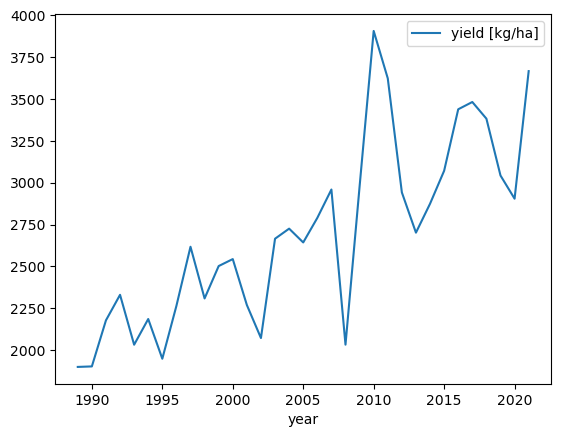

In [84]:
df_national.plot(x="year", y="yield [kg/ha]")

We will not detrend the yield data here for now

In [85]:
df_national.to_csv("data/crop/national_yield_with_trend.csv", index=False)
df_province.to_csv("data/crop/province_yield_with_trend.csv", index=False)